In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set()

In [73]:
class HIVTreatment:
    def __init__(self, args):
        self.state_names = ("T1", "T1*", "T2", "T2*", "V", "E")
    
        self.continuous_dims = np.arange(6)
        self.actions = np.array([[0., 0.], [.7, 0.], [0., .3], [.7, .3]])
        self.nA = 4
        self.episodeCap = args.episodeCap  #: total of 1000 days with a measurement every 5 days
        self.dt = 5  #: measurement every 5 days
        self.logspace = True  #: whether observed states are in log10 space or not
        #: only update the graphs in showDomain every x steps
        self.show_domain_every = 20
        # store samples of current episode for drawing
        self.episode_data = np.zeros((7, self.episodeCap + 1))

        if self.logspace:
            self.statespace_limits = np.array([[-5, 8]] * 6)
        else:
            self.statespace_limits = np.array([[0., 1e8]] * 6)
        self.state_space_dims = 6
        
        self.action_noise = args.action_noise
        self.action_sigma = args.action_sigma
        self.drop_p = args.drop_p
        
    def step(self, a):
        self.t += 1

        eps1, eps2 = self.actions[a]
        drop = False
        for mini_step in range(self.dt):
            eps1_noisy = max(eps1 + np.random.normal(self.action_noise, self.action_sigma), 0.0)
            eps2_noisy = max(eps2 + np.random.normal(self.action_noise, self.action_sigma), 0.0)
            
            p_drop = self.drop_p * (self.dt + 1 - mini_step)**-1
            if np.random.rand() <= p_drop or drop:
                eps1_noisy = 0
                eps2_noisy = 0
                drop = True
            ns = odeint(dsdt, self.state, [0, 1], #changed [0, dt] to [0, 1]
                    args=(eps1_noisy, eps2_noisy), mxstep=1000)[-1]
            T1, T2, T1s, T2s, V, E = ns
            # the reward function penalizes treatment because of side-effects
            reward = (- 0.1 * V - 2e4 * eps1_noisy ** 2 - 2e3 * eps2_noisy ** 2 + 1e3 * E)/1e5
            self.state = ns.copy()
            if self.logspace:
                ns = np.log10(ns)

        self.episode_data[:-1, self.t] = self.state
        self.episode_data[-1, self.t - 1] = a
        return self.normalizeState(ns), reward, self.isTerminal(), self.possibleActions()
    def normalizeState(self, s):
        return (s - self.statespace_limits[:, 0])/(self.statespace_limits[:, 1] - self.statespace_limits[:, 0])
    def isTerminal(self):
        return self.t >= self.episodeCap
    
    def possibleActions(self):
        return np.arange(4)

    def reset(self):
        self.t = 0
        self.episode_data[:] = np.nan
        # non-healthy stable state of the system
        s = np.array([163573., 5., 11945., 46., 63919., 24.])
        self.state = s.copy()
        self.episode_data[:-1, 0] = s
        if self.logspace:
            s = np.log10(s)
        return self.normalizeState(s)

def dsdt(s, t, eps1, eps2):
    """
    system derivate per time. The unit of time are days.
    """
    # model parameter constants
    lambda1 = 1e4
    lambda2 = 31.98
    d1 = 0.01
    d2 = 0.01
    f = .34
    k1 = 8e-7
    k2 = 1e-4
    delta = .7
    m1 = 1e-5
    m2 = 1e-5
    NT = 100.
    c = 13.
    rho1 = 1.
    rho2 = 1.
    lambdaE = 1
    bE = 0.3
    Kb = 100
    d_E = 0.25
    Kd = 500
    deltaE = 0.1

    # decompose state
    T1, T2, T1s, T2s, V, E = s

    # compute derivatives
    tmp1 = (1. - eps1) * k1 * V * T1
    tmp2 = (1. - f * eps1) * k2 * V * T2
    dT1 = lambda1 - d1 * T1 - tmp1
    dT2 = lambda2 - d2 * T2 - tmp2
    dT1s = tmp1 - delta * T1s - m1 * E * T1s
    dT2s = tmp2 - delta * T2s - m2 * E * T2s
    dV = (1. - eps2) * NT * delta * (T1s + T2s) - c * V \
        - ((1. - eps1) * rho1 * k1 * T1 +
           (1. - f * eps1) * rho2 * k2 * T2) * V
    dE = lambdaE + bE * (T1s + T2s) / (T1s + T2s + Kb) * E \
        - d_E * (T1s + T2s) / (T1s + T2s + Kd) * E - deltaE * E

    return np.array([dT1, dT2, dT1s, dT2s, dV, dE])

### Test Policy

Let's find the optimal policy for a short horizion

In [90]:
args = Namespace(**{'action_noise': 0, 'drop_p':0, 'action_sigma':0,\
                   'episodeCap': 4, 'num_episode': 1000, 'ifCVaR': True, 'opt': 0,\
                   'save_name': 'egreedy', 'alpha': 0.25, 'gamma': 0.99})
env = HIVTreatment(args)

In [91]:
def cv(res, alpha=0.25):
    cvar = np.zeros(res.shape[0])
    var = np.sort(res)[int(len(res) * alpha)]
    idx = np.where(res <= var)
    cvar = np.mean(res[idx])
    return cvar

In [92]:
from itertools import product
ret_cv = []
ret_mean = []
pi = []
for i in product([0, 1, 2, 3], repeat=4): 
    pi.append(list(i))
    s = env.reset()
    ret_pi = []
    for tr in range(100):
        s = env.reset()
        j = 0; t=False
        ret = []
        while not t:
            s, r, t, info = env.step(pi[-1][j])
            ret.append(r)
            j += 1
        ret_pi.append(discounted_return(ret, args.gamma))
    ret_pi = np.array(ret_pi)
    ret_cv.append(cv(ret_pi, args.alpha))
    ret_mean.append(np.mean(ret_pi))

Text(0.5,0,'return')

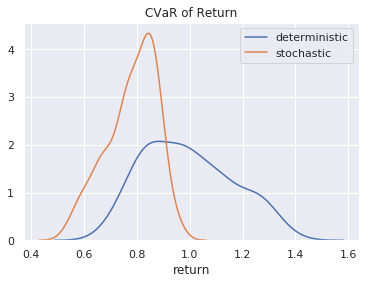

In [97]:
#st_cv = ret_cv
#st_mean = ret_mean
sns.kdeplot(ret_cv, label='deterministic')
sns.kdeplot(st_cv, label='stochastic')
plt.title('CVaR of Return')
plt.xlabel('return')

Text(0.5,0,'return')

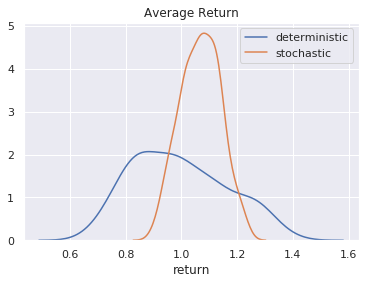

In [96]:
sns.kdeplot(ret_mean, label='deterministic')
sns.kdeplot(st_mean, label='stochastic')
plt.title('Average Return')
plt.xlabel('return')

0.5533346918043969
0.9516742002751399


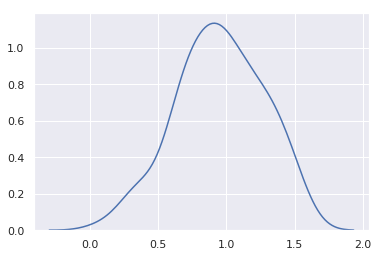

In [86]:
sns.kdeplot(ret_pi)
print(cv(ret_pi, args.alpha))
print(np.mean(ret_pi))

In [87]:
idx = np.argmax(ret_mean)
print(idx)
print(pi[idx][:])
print(np.max(ret_mean))
idx = np.argmax(ret_cv)
print(idx)
print(pi[idx][:])
print(np.max(ret_cv))
print(ret_cv[56])

226
[3, 2, 0, 2]
1.2279255854058886
104
[1, 2, 2, 0]
0.964168567762034
0.8574140411890862


In [18]:
# test to see if it's deterministc

0.46491852080582674


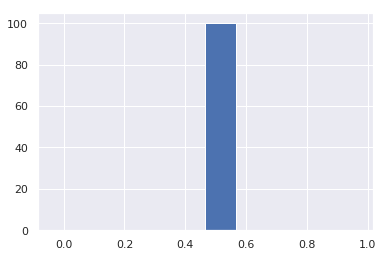

In [9]:
ret_dist = []
pi = [2, 2]
for i in range(100):
    s = env.reset()
    ret = []
    for j in range(2):
        s, r, t, info = env.step(pi[j])
        ret.append(r)
    ret_dist.append(discounted_return(ret, 0.99))
plt.hist(ret_dist)
print(np.mean(ret_dist))

### e-greedy learning of the average

In [74]:
from core import config, drl, replay
import tensorflow as tf
from argparse import Namespace

def discounted_return(returns, gamma):
    ret = 0
    for r in reversed(returns):
        ret = r + gamma * ret
    return ret

/home/ramtin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [114]:
args = Namespace(**{'action_noise': 0, 'drop_p':0, 'action_sigma':0,\
                   'episodeCap': 20, 'num_episode': 6000, 'ifCVaR': False, 'opt': 0,\
                   'save_name': 'egreedy', 'alpha': 0.25, 'gamma': 0.99})
tf.reset_default_graph()
with tf.Session() as sess:
    env = HIVTreatment(args)
    Config = config.config(env, args)
    Config.max_step = env.episodeCap
    
    returns = np.zeros((Config.args.num_episode, 2))
    replay_buffer = replay.Replay(Config, load=False)
    counts = np.ones((1, Config.nA))
    C51 = drl.C51(Config, ifCVaR=Config.args.ifCVaR, memory=replay_buffer)
    saver = tf.train.Saver()
    sess.run(tf.initializers.global_variables())
    print("[*] TF model initialized")

    summary_writer = tf.summary.FileWriter(args.save_name + '/summary', sess.graph)
    C51_loss = []
    train_step = 0
    
    for ep in range(Config.args.num_episode):
        terminal = False
        step = 0
        lr = Config.get_lr(ep)
        epsilon = Config.get_epsilon(ep)
 
        episode_return = []
        observation = env.reset()
        pi = []
        while not terminal:
            if np.random.rand() <= epsilon:
                action_id = np.random.randint(Config.nA)
            else:
                if Config.args.ifCVaR:
                    o = np.expand_dims(observation, axis=0)
                    counts = np.ones((1, Config.nA))
                    distribution = C51.predict(sess, o)
                    values = C51.CVaRopt(distribution, count=counts,\
                                 alpha=Config.args.alpha, N=Config.CVaRSamples, c=args.opt, bonus=0.0)
                else:
                    o = np.expand_dims(observation, axis=0)
                    distribution = C51.predict(sess, o)
                    values = C51.Q(distribution)
                action_id = np.random.choice(np.flatnonzero(values == values.max()))
            next_observation, reward, terminal, info = env.step(action_id)
            pi.append(action_id)
            step += 1
            no = np.expand_dims(next_observation, axis=0)
            next_counts = counts # hack to avoind passing counts
            episode_return.append(reward)
            if step >= Config.max_step:
                terminal = True
                 
            replay_buffer.add(observation, action_id, reward, terminal,\
                                 counts, next_counts)
            # Training:
            l, _ = C51.train(sess=sess, size=Config.train_size, opt=args.opt, learning_rate = lr)
                         
            #if ep%Config.summary_write_episode == 0 and summary is not None:
            #    summary_writer.add_summary(summary, train_step)
            train_step += 1
            if l is not None:
                C51_loss.append(l)
                returns[ep, 1] = l
            observation = next_observation   
        returns[ep, 0] = discounted_return(episode_return, Config.args.gamma)
        if ep%Config.print_episode == 0:
            print("Training.  Episode ep:%3d, Discounted Return = %g, Epsilon = %g, Lr = %g, C51 average loss=%g"\
                         %(ep, returns[ep, 0], epsilon, lr, np.mean(C51_loss)))
        if ep% Config.save_episode == 0:
            save_file = {'ep': ep, 'returns': returns}
            replay_buffer.save(args.save_name)
            pickle_in = open(args.save_name + '.p', 'wb')
            pickle.dump(save_file, pickle_in)
            pickle_in.close()
            saver.save(sess, args.save_name + '.ckpt')

Initialzing the replay buffer
[*] TF model initialized
Training.  Episode ep:  0, Discounted Return = 6.50758, Epsilon = 0.9, Lr = 0.001, C51 average loss=3.80667
Replay buffer saved, name:egreedy.p
Training.  Episode ep:100, Discounted Return = 12.0893, Epsilon = 0.871667, Lr = 0.00097, C51 average loss=2.57689
Training.  Episode ep:200, Discounted Return = 6.89592, Epsilon = 0.843333, Lr = 0.00094, C51 average loss=2.62348
Training.  Episode ep:300, Discounted Return = 9.77344, Epsilon = 0.815, Lr = 0.00091, C51 average loss=2.57397
Training.  Episode ep:400, Discounted Return = 7.61423, Epsilon = 0.786667, Lr = 0.00088, C51 average loss=2.53355
Training.  Episode ep:500, Discounted Return = 7.17879, Epsilon = 0.758333, Lr = 0.00085, C51 average loss=2.49657
Training.  Episode ep:600, Discounted Return = 3.5874, Epsilon = 0.73, Lr = 0.00082, C51 average loss=2.46368
Training.  Episode ep:700, Discounted Return = 6.77362, Epsilon = 0.701667, Lr = 0.00079, C51 average loss=2.43773
Trai

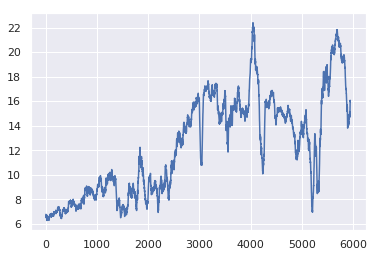

In [128]:
plt.plot(mv(returns[:, 0], 50))

In [5]:
def mv(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

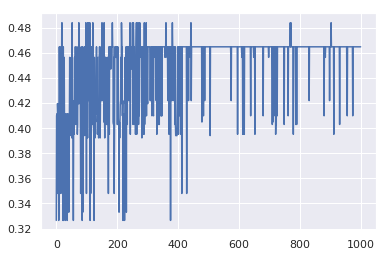

In [8]:
plt.plot(returns[:, 0])

In [26]:
Config.args.gamma

0.99

## Determinisitic Env, with 20 actionable steps and full period

In [24]:
data = pickle.load(open('results/det_exp_test_5000.p', 'rb'))

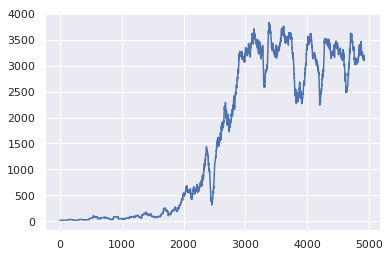

In [27]:
plt.plot(mv(data['returns'][:5000, 0], 75))

In [43]:
## Stochastic Env, with 20 actionable steps and full period, 5 diff stochasticity


In [44]:
def cv(res, alpha=0.25):
    cvar = np.zeros(res.shape[0])
    var = np.sort(res)[int(len(res) * alpha)]
    idx = np.where(res <= var)
    cvar = np.mean(res[idx])
    return cvar

Text(0.5,1,'CVaR s')

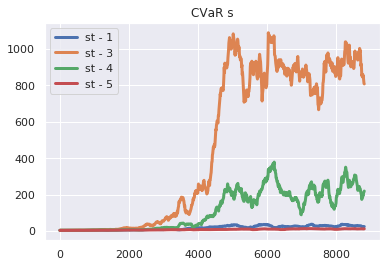

In [58]:
sam = 1000
for ii in [1, 3, 4, 5]:
    data = pickle.load(open('results/st%d_exp_arch3_9000.p'%(ii), 'rb'))
    returns = data['returns'][:9000, 0]
    cv_ret = returns.reshape((sam, -1))
    num = returns.shape[0]
    c = np.zeros((sam))
    for i in range(sam):
        c[i] = cv(cv_ret[i, :])
    ep = np.arange(sam) * num/sam
    plt.plot(ep[:-19], mv(c, 20), label='st - %d'%(ii), linewidth = 3)
plt.legend()
plt.title("CVaR s")

Text(0.5,1,'Retuns')

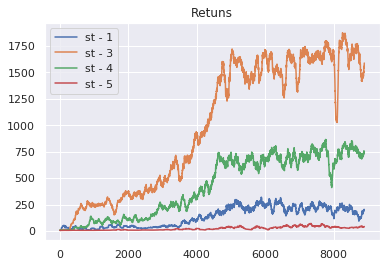

In [54]:
## Stochastic Env, with 20 actionable steps and full period, 5 diff stochasticity
for i in [1, 3, 4, 5]:
    data = pickle.load(open('results/st%d_exp_arch1_9000.p'%(i), 'rb'))

    plt.plot(mv(data['returns'][:9000, 0], 100), label = 'st - %d'%(i))
plt.legend()
plt.title("Retuns")

Now, let's take last 4000 episodes and look at the returns

In [69]:
data = pickle.load(open('results/st3_exp_arch1_9000.p', 'rb'))['returns'][6000:9000, 0]

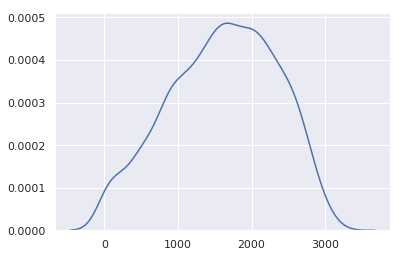

In [70]:
sns.kdeplot(data)

In [72]:
## Let's load the model and see the results

In [89]:
from utils.hiv_env import *

args = Namespace(**{'action_noise': 0, 'drop_p':0, 'action_sigma':0,\
                   'episodeCap': 20, 'num_episode': 6000, 'ifCVaR': False, 'opt': 0,\
                   'save_name': 'egreedy', 'alpha': 0.25, 'gamma': 0.99, 'load_name': 'results/st3_exp_arch1',\
                   'arch': 1, 'st': 3, 'seed': 1, 'actionable_time_steps': 20, 'normalize_state' : True,\
                   'normalize_reward': True})
tf.reset_default_graph()
with tf.Session() as sess:
    env = HIVTreatment(args)
    Config = config.config(env, args)
    Config.max_step = env.episodeCap
    
    load_file = pickle.load(open(args.load_name + '_9000.p', 'rb'))
    counts = np.ones((1, Config.nA))
    C51 = drl.C51(Config, ifCVaR=Config.args.ifCVaR, memory=None)
    returns = load_file["returns"]
    initial_ep = load_file["ep"]
    saver = tf.train.Saver()
    saver.restore(sess, args.load_name + '.ckpt')
    print("[*] TF model restored")
    
    tot_return = []
    for ep in range(500):
        terminal = False
        step = 0
        lr = Config.get_lr(ep)
        epsilon = Config.get_epsilon(ep)
 
        episode_return = []
        observation = env.reset()
        pi = []
        while not terminal:
            o = np.expand_dims(observation, axis=0)
            distribution = C51.predict(sess, o)
            values = C51.Q(distribution)
            action_id = np.random.choice(np.flatnonzero(values == values.max()))
            next_observation, reward, terminal, info = env.step(action_id)
            pi.append(action_id)
            step += 1
            no = np.expand_dims(next_observation, axis=0)
            next_counts = counts # hack to avoind passing counts
            episode_return.append(reward)
            if step >= Config.max_step:
                terminal = True
                 
            observation = next_observation   
        tot_return.append(discounted_return(episode_return, Config.args.gamma))
        print(ep, discounted_return(episode_return, Config.args.gamma))

INFO:tensorflow:Restoring parameters from results/st3_exp_arch1.ckpt
[*] TF model restored
0 2633.275970127932
1 2027.5784186898647
2 2555.3892405866845
3 546.5228100276108
4 1648.2676320367323
5 2559.449369986446
6 2282.5210109690724
7 1838.061576303991
8 1736.4629874273135
9 2206.3599726921298
10 1709.4157542791854
11 2560.2168963654844
12 2742.4306846785266
13 2202.6236083891363
14 2185.035895089606
15 1734.94339417968
16 2994.345957717753
17 2359.9526406634754
18 1192.4892412993443
19 2279.0046592713516
20 1371.9251750421806
21 1571.0701204170489
22 2374.7120241546713
23 685.8642304656138
24 1914.02537505873
25 2217.382642053913
26 2604.838779334566
27 1644.3026100209668
28 2329.86894228062
29 2670.3297993784136
30 2558.4434233507554
31 2266.7904386187315
32 1172.2799048598213
33 465.4910066075349
34 2696.071934622636
35 1346.60158690132
36 1707.4997242685024
37 2572.0704895028457
38 2301.8758650648115
39 2359.7970945147044
40 972.5798441436424
41 1945.8884819602763
42 2031.1179773

364 1968.5248004369114
365 606.1239622402026
366 2338.4831452278186
367 860.6269591717477
368 2663.8800946151173
369 2719.2212847651517
370 2367.6841954605134
371 1300.0077269049577
372 2175.5967740705523
373 871.7572944686285
374 1525.2454578670022
375 1910.4278851585468
376 1599.636894407328
377 2121.6909089196215
378 2517.2434502307265
379 2161.535827351539
380 2728.327610863354
381 1788.3370153824417
382 1805.8459789271742
383 1897.0369726108902
384 1687.5572519299812
385 1748.379161817237
386 1676.417404608114
387 2458.791527157314
388 1637.8336834043544
389 2305.2747993283183
390 2716.5617960216982
391 1353.2920993148925
392 1787.3871245237174
393 1430.2451822863409
394 1904.929615965127
395 1501.0009934529185
396 974.4256696474914
397 2396.7644563664326
398 1682.8701678020152
399 2732.4038773358275
400 2599.8294616797934
401 1913.4341609820372
402 2825.8345540909186
403 2226.2577306797134
404 2635.647615591021
405 1589.6499964861184
406 2378.996007865939
407 2781.7769966110827
4

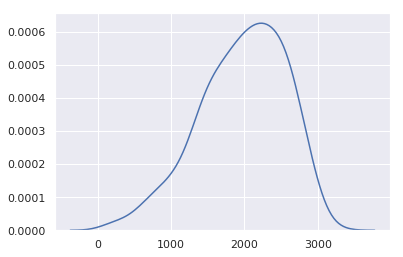

In [90]:
sns.kdeplot(tot_return)

So it does make sense, now let's see if CVaR learning would do something

Adding evaluation

In [161]:
data = pickle.load(open('results/test_with_evaluation_exp_500.p', 'rb'))

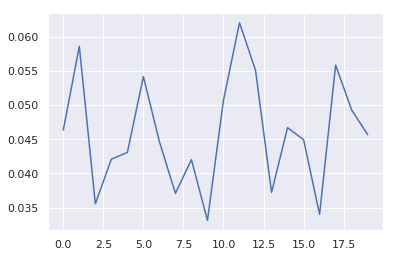

In [162]:
plt.plot(np.mean(data['evaluation_returns'], axis = 0))

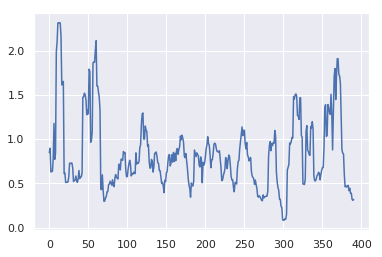

In [163]:
plt.plot(mv(data['returns'][:400, 0], 10))

In [164]:
data['evaluation_returns']

array([[0.00697401, 0.00698179, 0.00698248, 0.0069911 , 0.00698164,
        0.00697973, 0.00697177, 0.00698283, 0.00699292, 0.00697502,
        0.00699911, 0.00698132, 0.00699178, 0.00699217, 0.0069729 ,
        0.00699061, 0.0069728 , 0.00697657, 0.00697398, 0.00697845],
       [0.00830059, 0.00825966, 0.00824612, 0.00823579, 0.00822987,
        0.00822944, 0.00820422, 0.00830211, 0.00824965, 0.00839189,
        0.00826112, 0.00830508, 0.00826557, 0.00830222, 0.00822757,
        0.00828966, 0.00827724, 0.00824765, 0.00822604, 0.00827496],
       [0.5508163 , 0.72000765, 0.42273956, 0.52152343, 0.60342262,
        0.78257924, 0.52642865, 0.45954426, 0.64152928, 0.25971409,
        0.51916321, 0.94004766, 0.80300339, 0.57406404, 0.62339226,
        0.54577275, 0.46314725, 0.70352122, 0.56224789, 0.71566762],
       [0.3085691 , 0.37608935, 0.24223373, 0.33859026, 0.27743168,
        0.33013588, 0.2887093 , 0.26391674, 0.21696067, 0.2211768 ,
        0.34288539, 0.33801332, 0.32973438, 0